## Imports

In [2]:
# Imports

#General
import numpy as np
import itertools

# System
import os, fnmatch

# Data
import pandas as pd

# Visualization
import seaborn 
import matplotlib.pyplot as plt
from IPython.core.display import HTML, display, Image

# Machine Learning
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report


# Deep Learning
import tensorflow as tf
from tensorflow.python.client import device_lib 
from keras.backend.tensorflow_backend import set_session
from tensorflow.python.client import device_lib
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Input, Convolution2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, merge
from keras.layers.normalization import BatchNormalization
from keras.callbacks import History, EarlyStopping, ModelCheckpoint
from keras.models import load_model


# Random Seed
from tensorflow import set_random_seed
from numpy.random import seed
seed(0)
set_random_seed(0)

# Audio
import librosa.display, librosa
from librosa.util import normalize as normalize
import IPython.display as ipd

# Configurations
path='./BirdSound/'

## Configurations for Google Colab

In [119]:
"""
# Only for Google Colab
try:
    import google.colab
    if "GPU:0" in tf.test.gpu_device_name():
        !nvidia-smi
        config = tf.ConfigProto(log_device_placement=True, allow_soft_placement=True, device_count = {'GPU': 0})
        config.gpu_options.allow_growth = True
        session = tf.Session(config=config)
        set_session(session)
    else:
        print("No GPU Detected. Configure the Runtime.")
    !git clone https://github.com/GuitarsAI/BasicsMusicalInstrumClassifi
    !unzip ./BasicsMusicalInstrumClassifi/audio/*.zip -d ./BasicsMusicalInstrumClassifi/audio
    path="./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/"
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
    tf.logging.set_verbosity(tf.logging.ERROR)
    from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
    
except Exception as e:
    print("Not inside Google Colab: %s. Using standard configurations." % (e))
    !cat /proc/cpuinfo
 
"""

'\n# Only for Google Colab\ntry:\n    import google.colab\n    if "GPU:0" in tf.test.gpu_device_name():\n        !nvidia-smi\n        config = tf.ConfigProto(log_device_placement=True, allow_soft_placement=True, device_count = {\'GPU\': 0})\n        config.gpu_options.allow_growth = True\n        session = tf.Session(config=config)\n        set_session(session)\n    else:\n        print("No GPU Detected. Configure the Runtime.")\n    !git clone https://github.com/GuitarsAI/BasicsMusicalInstrumClassifi\n    !unzip ./BasicsMusicalInstrumClassifi/audio/*.zip -d ./BasicsMusicalInstrumClassifi/audio\n    path="./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/"\n    os.environ[\'TF_CPP_MIN_LOG_LEVEL\'] = \'3\'\n    tf.logging.set_verbosity(tf.logging.ERROR)\n    from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback\n    \nexcept Exception as e:\n    print("Not inside Google Colab: %s. Using standard configurations." % (e))\n    !cat /proc/cpuinfo\n \n'

## Parameters

In [3]:
# Signal Processing Parameters
fs = 44100         # Sampling Frequency
n_fft = 2048       # length of the FFT window
hop_length = 512   # Number of samples between successive frame
# Machine Learning Parameters
testset_size = 0.25 #Percentage of data for Testing

## Find Audio Files, Generate Labels and Get Duration

In [4]:
#Find Audio Files
files = []
labels =[]
duration = []
#classes=['flute','sax','oboe', 'cello','trumpet','viola']
classes=['Avocet','Coot','Crake','Crane','Dove','Gallinule','Grebe','Grouse','Lapwing','Nightjar',
         'Oystercatcher','Pheasant','Pigeon','Plover','Quail','Rail','Sandpiper','Stilt','Swift','Turaco']
for root, dirnames, filenames in os.walk(path):
    for i, filename in enumerate(fnmatch.filter(filenames, '*.wav')):
        files.append(os.path.join(root, filename))
        for name in classes:
            if fnmatch.fnmatchcase(filename, '*'+name+'*'):
                labels.append(name)
                break
        else:
            labels.append('other')
        print ("Get %d = %s"%(i+1, filename))
        try:
            y, sr = librosa.load(files[i], sr=fs)
            if len(y) < 2:
                print("Error loading %s" % filename)
                continue
            #y/=y.max() #Normalize
            yt, index = librosa.effects.trim(y,top_db=60) #Trim
            duration.append(librosa.get_duration(yt, sr=fs))
        except Exception as e:
            print("Error loading %s. Error: %s" % (filename,e))


print("found %d audio files in %s"%(len(files),path))

Get 1 = XC131319 - Common Gallinule - Gallinula galeata.wav
Get 2 = XC465599 - Common Gallinule - Gallinula galeata cachinnans.wav
Get 3 = XC452961 - Common Gallinule - Gallinula galeata.wav
Get 4 = XC45353 - Spot-flanked Gallinule - Porphyriops melanops crassirostris.wav
Get 5 = XC91834 - Spot-flanked Gallinule - Porphyriops melanops.wav
Get 6 = XC414334 - Common Gallinule - Gallinula galeata.wav
Get 7 = XC368531 - Common Gallinule - Gallinula galeata.wav
Get 8 = XC37123 - Purple Gallinule - Porphyrio martinica.wav
Get 9 = XC7979 - Common Gallinule - Gallinula galeata.wav
Get 10 = XC246282 - Common Gallinule - Gallinula galeata.wav
Get 11 = XC384693 - Common Gallinule - Gallinula galeata.wav
Get 12 = XC326531 - Purple Gallinule - Porphyrio martinica.wav
Get 13 = XC51100 - Purple Gallinule - Porphyrio martinica.wav
Get 14 = XC298133 - Common Gallinule - Gallinula galeata.wav
Get 15 = XC264307 - Purple Gallinule - Porphyrio martinica.wav
Get 16 = XC166168 - Purple Gallinule - Porphyrio 

Get 13 = XC384011 - Gambel's Quail - Callipepla gambelii.wav
Get 14 = XC53487 - California Quail - Callipepla californica.wav
Get 15 = XC263366 - Common Quail - Coturnix coturnix.wav
Get 16 = XC113194 - Ruddy Quail-Dove - Geotrygon montana.wav
Get 17 = XC238713 - Rufous-fronted Wood Quail - Odontophorus erythrops parambae.wav
Get 18 = XC310823 - Marbled Wood Quail - Odontophorus gujanensis.wav
Get 19 = XC35850 - Spot-winged Wood Quail - Odontophorus capueira.wav
Get 20 = XC3107 - Stripe-faced Wood Quail - Odontophorus balliviani.wav
Get 1 = XC141694 - Pied Avocet - Recurvirostra avosetta.wav
Get 2 = XC2479 - Andean Avocet - Recurvirostra andina.wav
Get 3 = XC333699 - Pied Avocet - Recurvirostra avosetta.wav
Get 4 = XC199264 - Pied Avocet - Recurvirostra avosetta.wav
Get 5 = XC133080 - American Avocet - Recurvirostra americana.wav
Get 6 = XC188266 - Pied Avocet - Recurvirostra avosetta.wav
Get 7 = XC325032 - Pied Avocet - Recurvirostra avosetta.wav
Get 8 = XC313293 - Pied Avocet - Recur

Get 13 = XC185652 - Little Grebe - Tachybaptus ruficollis.wav
Get 14 = XC460157 - Great Crested Grebe - Podiceps cristatus.wav
Get 15 = XC43482 - Little Grebe - Tachybaptus ruficollis.wav
Get 16 = XC362173 - Little Grebe - Tachybaptus ruficollis.wav
Get 17 = XC83320 - Least Grebe - Tachybaptus dominicus.wav
Get 18 = XC314998 - Little Grebe - Tachybaptus ruficollis.wav
Get 19 = XC51138 - White-tufted Grebe - Rollandia rolland.wav
Get 20 = XC54500 - Pied-billed Grebe - Podilymbus podiceps antarcticus.wav
Get 21 = XC26547 - Great Crested Grebe - Podiceps cristatus cristatus.wav
Get 22 = XC424675 - Little Grebe - Tachybaptus ruficollis.wav
Get 23 = XC466329 - Little Grebe - Tachybaptus ruficollis.wav
Get 24 = XC373560 - Little Grebe - Tachybaptus ruficollis.wav
Get 25 = XC55584 - Least Grebe - Tachybaptus dominicus.wav
Get 1 = XC14345 - Purple-crowned Plovercrest - Stephanoxis loddigesii.wav
Get 2 = XC429053 - Purple-crowned Plovercrest - Stephanoxis loddigesii.wav
Get 3 = XC450072 - Magel

Get 1 = XC193722 - Black-winged Stilt - Himantopus himantopus.wav
Get 2 = XC145752 - Black-necked Stilt - Himantopus mexicanus.wav
Get 3 = XC177581 - Black-necked Stilt - Himantopus mexicanus.wav
Get 4 = XC93965 - Black-winged Stilt - Himantopus himantopus (1).wav
Get 5 = XC174956 - Black-necked Stilt - Himantopus mexicanus.wav
Get 6 = XC147547 - White-backed Stilt - Himantopus melanurus.wav
Get 7 = XC269525 - Black-winged Stilt - Himantopus himantopus.wav
Get 8 = XC304651 - Black-necked Stilt - Himantopus mexicanus.wav
Get 9 = XC280353 - Black-winged Stilt - Himantopus himantopus.wav
Get 10 = XC328055 - Black-winged Stilt - Himantopus himantopus.wav
Get 11 = XC184127 - Black-winged Stilt - Himantopus himantopus.wav
Get 12 = XC352343 - Black-necked Stilt - Himantopus mexicanus mexicanus.wav
Get 13 = XC338804 - Black-winged Stilt - Himantopus himantopus.wav
Get 14 = XC224234 - Black-necked Stilt - Himantopus mexicanus.wav
Get 15 = XC261421 - Black-necked Stilt - Himantopus mexicanus.wav

In [5]:
print("Max. Duration:", max(duration))
print("Min. Duration:", min(duration))
print("Average Duration:", np.mean(duration))

Max. Duration: 25.583356009070293
Min. Duration: 4.41469387755102
Average Duration: 10.254275132275131


## Trim Silence and Recalculate Duration

In [6]:
# Load audio files, trim silence and calculate duration
duration = []
for i,f in enumerate(files):
    print ("Get %d  %s"%(i+1, f))
    try:
        y, sr = librosa.load(f, sr=fs)
        if len(y) < 2:
            print("Error loading %s" % f)
            continue
        #y/=y.max() #Normalize
        yt, index = librosa.effects.trim(y,top_db=60) #Trim
        duration.append(librosa.get_duration(yt, sr=fs))
    except Exception as e:
        print("Error loading %s. Error: %s" % (f,e))
        
print("Calculated %d Durations"%len(duration))

Get 1  ./BirdSound/Gallinule/XC131319 - Common Gallinule - Gallinula galeata.wav
Get 2  ./BirdSound/Gallinule/XC465599 - Common Gallinule - Gallinula galeata cachinnans.wav
Get 3  ./BirdSound/Gallinule/XC452961 - Common Gallinule - Gallinula galeata.wav
Get 4  ./BirdSound/Gallinule/XC45353 - Spot-flanked Gallinule - Porphyriops melanops crassirostris.wav
Get 5  ./BirdSound/Gallinule/XC91834 - Spot-flanked Gallinule - Porphyriops melanops.wav
Get 6  ./BirdSound/Gallinule/XC414334 - Common Gallinule - Gallinula galeata.wav
Get 7  ./BirdSound/Gallinule/XC368531 - Common Gallinule - Gallinula galeata.wav
Get 8  ./BirdSound/Gallinule/XC37123 - Purple Gallinule - Porphyrio martinica.wav
Get 9  ./BirdSound/Gallinule/XC7979 - Common Gallinule - Gallinula galeata.wav
Get 10  ./BirdSound/Gallinule/XC246282 - Common Gallinule - Gallinula galeata.wav
Get 11  ./BirdSound/Gallinule/XC384693 - Common Gallinule - Gallinula galeata.wav
Get 12  ./BirdSound/Gallinule/XC326531 - Purple Gallinule - Porphyr

Get 102  ./BirdSound/Crake/XC69265 - Spotless Crake - Porzana tabuensis.wav
Get 103  ./BirdSound/Crake/XC288426 - Grey-breasted Crake - Laterallus exilis.wav
Get 104  ./BirdSound/Crake/XC218852 - Russet-crowned Crake - Laterallus viridis.wav
Get 105  ./BirdSound/Crake/XC13469 - Black-banded Crake - Laterallus fasciatus.wav
Get 106  ./BirdSound/Crake/XC55476 - Ash-throated Crake - Porzana albicollis.wav
Get 107  ./BirdSound/Crake/XC119289 - Russet-crowned Crake - Laterallus viridis.wav
Get 108  ./BirdSound/Crake/XC210825 - Rufous-sided Crake - Laterallus melanophaius.wav
Get 109  ./BirdSound/Crake/XC45671 - Rufous-sided Crake - Laterallus melanophaius.wav
Get 110  ./BirdSound/Crake/XC94670 - Russet-crowned Crake - Laterallus viridis.wav
Get 111  ./BirdSound/Crake/XC54440 - White-throated Crake - Laterallus albigularis albigularis.wav
Get 112  ./BirdSound/Crake/XC371591 - Spotted Crake - Porzana porzana.wav
Get 113  ./BirdSound/Crake/XC153920 - Black Crake - Amaurornis flavirostra (2).wa

Get 202  ./BirdSound/Coot/XC48552 - Red-gartered Coot - Fulica armillata.wav
Get 203  ./BirdSound/Coot/XC48553 - Red-gartered Coot - Fulica armillata.wav
Get 204  ./BirdSound/Coot/XC37445 - Eurasian Coot - Fulica atra.wav
Get 205  ./BirdSound/Coot/XC50787 - Red-gartered Coot - Fulica armillata.wav
Get 206  ./BirdSound/Coot/XC8578 - White-winged Coot - Fulica leucoptera.wav
Get 207  ./BirdSound/Coot/XC17280 - Andean Coot - Fulica ardesiaca.wav
Get 208  ./BirdSound/Coot/XC50788 - White-winged Coot - Fulica leucoptera.wav
Get 209  ./BirdSound/Coot/XC44706 - Eurasian Coot - Fulica atra atra.wav
Get 210  ./BirdSound/Coot/XC175425 - Eurasian Coot - Fulica atra.wav
Get 211  ./BirdSound/Coot/XC89324 - American Coot - Fulica americana.wav
Get 212  ./BirdSound/Coot/XC28533 - Eurasian Coot - Fulica atra.wav
Get 213  ./BirdSound/Coot/XC123344 - American Coot - Fulica americana.wav
Get 214  ./BirdSound/Coot/XC14381 - American Coot - Fulica americana.wav
Get 215  ./BirdSound/Coot/XC153335 - American

Get 303  ./BirdSound/Lapwing/XC92841 - Crowned Lapwing - Vanellus coronatus.wav
Get 304  ./BirdSound/Lapwing/XC300855 - Spot-breasted Lapwing - Vanellus melanocephalus (1).wav
Get 305  ./BirdSound/Lapwing/XC269626 - Grey-headed Lapwing - Vanellus cinereus.wav
Get 306  ./BirdSound/Lapwing/XC240821 - Crowned Lapwing - Vanellus coronatus.wav
Get 307  ./BirdSound/Lapwing/XC50272 - Southern Lapwing - Vanellus chilensis.wav
Get 308  ./BirdSound/Lapwing/XC94304 - Red-wattled Lapwing - Vanellus indicus atronuchalis.wav
Get 309  ./BirdSound/Lapwing/XC169890 - Northern Lapwing - Vanellus vanellus.wav
Get 310  ./BirdSound/Lapwing/XC184638 - Red-wattled Lapwing - Vanellus indicus indicus.wav
Get 311  ./BirdSound/Lapwing/XC81962 - Grey-headed Lapwing - Vanellus cinereus.wav
Get 312  ./BirdSound/Lapwing/XC108381 - Southern Lapwing - Vanellus chilensis.wav
Get 313  ./BirdSound/Lapwing/XC429527 - Spur-winged Lapwing - Vanellus spinosus.wav
Get 314  ./BirdSound/Lapwing/XC147425 - Northern Lapwing - Van

Get 396  ./BirdSound/Stilt/XC147547 - White-backed Stilt - Himantopus melanurus.wav
Get 397  ./BirdSound/Stilt/XC269525 - Black-winged Stilt - Himantopus himantopus.wav
Get 398  ./BirdSound/Stilt/XC304651 - Black-necked Stilt - Himantopus mexicanus.wav
Get 399  ./BirdSound/Stilt/XC280353 - Black-winged Stilt - Himantopus himantopus.wav
Get 400  ./BirdSound/Stilt/XC328055 - Black-winged Stilt - Himantopus himantopus.wav
Get 401  ./BirdSound/Stilt/XC184127 - Black-winged Stilt - Himantopus himantopus.wav
Get 402  ./BirdSound/Stilt/XC352343 - Black-necked Stilt - Himantopus mexicanus mexicanus.wav
Get 403  ./BirdSound/Stilt/XC338804 - Black-winged Stilt - Himantopus himantopus.wav
Get 404  ./BirdSound/Stilt/XC224234 - Black-necked Stilt - Himantopus mexicanus.wav
Get 405  ./BirdSound/Stilt/XC261421 - Black-necked Stilt - Himantopus mexicanus.wav
Get 406  ./BirdSound/Stilt/XC257542 - Black-necked Stilt - Himantopus mexicanus mexicanus.wav
Get 407  ./BirdSound/Stilt/XC128124 - Black-winged 

## Duration Distribution

Duration average: 21.98161929957168


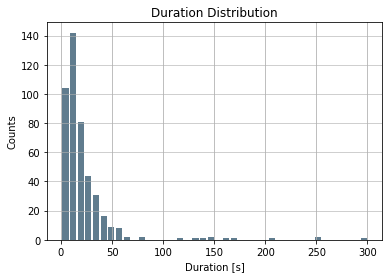

In [7]:
durationDist = pd.Series(np.array(duration))
plt.figure()
durationDist.plot.hist(grid=True, bins=40, rwidth=0.8,
                   color='#607c8e')
plt.title('Duration Distribution')
plt.xlabel('Duration [s]')
plt.ylabel('Counts')
plt.grid(axis='y', alpha=0.75)
print("Duration average:",np.mean(duration))

## Short-Time Fourier Transform

In [8]:
#show_web("https://en.wikipedia.org/wiki/Short-time_Fourier_transform")

Spectogram Array Shape: (1025, 87)


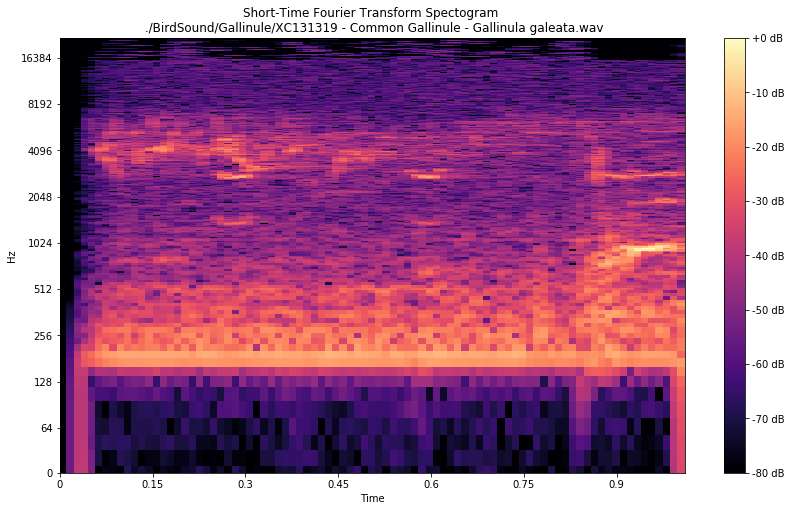

In [9]:
# STFT Example
y, sr = librosa.load(files[10], sr=fs, duration=1)
y/=y.max() #Normalize
duration_in_samples=librosa.time_to_samples(1, sr=fs)
y_pad = librosa.util.fix_length(y, duration_in_samples) #Pad to 1s if smaller
y_stft=librosa.core.stft(y_pad, n_fft=n_fft, hop_length=hop_length)
y_spec=librosa.amplitude_to_db(abs(y_stft), np.max)
plt.figure(figsize=(14,8))
plt.title("Short-Time Fourier Transform Spectogram \n %s"%files[0])
librosa.display.specshow(y_spec,sr=fs,y_axis='log', x_axis='time')
plt.colorbar(format='%+2.0f dB');
print("Spectogram Array Shape:",y_spec.shape)
ipd.Audio(y, rate=fs)

## Encode Labels

In [10]:
# Encode Labels
labelencoder = LabelEncoder()
labelencoder.fit(labels)
print(len(labelencoder.classes_), "classes:", ", ".join(list(labelencoder.classes_)))
classes_num = labelencoder.transform(labels)

#OneHotEncoding
encoder=OneHotEncoder(sparse=False, categories="auto")
onehot_labels=encoder.fit_transform(classes_num.reshape(len(classes_num),1))

21 classes: Avocet, Coot, Crake, Crane, Dove, Gallinule, Grebe, Grouse, Lapwing, Nightjar, Oystercatcher, Pheasant, Pigeon, Plover, Quail, Rail, Sandpiper, Stilt, Swift, Turaco, other


## Train and Test Sets

In [11]:
# Create Train and Test Sets
splitter = StratifiedShuffleSplit(n_splits=1, test_size=testset_size, random_state=0)
splits = splitter.split(files, onehot_labels)
files_arr=np.array(files)

for train_index, test_index in splits:
    train_set_files = files_arr[train_index]
    test_set_files = files_arr[test_index]
    train_classes = onehot_labels[train_index]
    test_classes = onehot_labels[test_index]

## Convolutional Neural Networks

In [12]:
#show_web("https://en.wikipedia.org/wiki/Convolutional_neural_network")

## Create Model

In [13]:
# CNN Model
model = Sequential()

conv_filters =  16  # number of convolution filters

# Layer 1
model.add(Convolution2D(conv_filters, 3,input_shape=(1025, 87, 1)))
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Dropout(0.40)) 

# Layer 2
model.add(Convolution2D(conv_filters, 3))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

# Flatten
model.add(Flatten()) 

# Full layer
model.add(Dense(70, activation='sigmoid')) 

# Output layer
model.add(Dense(21,activation='softmax'))

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1023, 85, 16)      160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 511, 42, 16)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 511, 42, 16)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 509, 40, 16)       2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 254, 20, 16)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 254, 20, 16)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 81280)            

In [15]:
# Loss Function 
loss = 'categorical_crossentropy' 

# Optimizer = Gradient Descent
optimizer = 'sgd' 

# Compile
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

## Train Model

In [16]:
def featureGenerator(files, labels):
    while True:
        for i,f in enumerate(files):
            try:
                feature_vectors = []
                label = []
                y, sr = librosa.load(f, sr=fs)
                if len(y) < 2:
                    print("Error loading %s" % f)
                    continue
                y, index = librosa.effects.trim(y,top_db=60) #Trim
                y = normalize(y)
                duration_in_samples=librosa.time_to_samples(1, sr=fs)
                y_pad = librosa.util.fix_length(y, duration_in_samples) #Pad/Trim to same duration
                y_stft=librosa.core.stft(y_pad, n_fft=n_fft, hop_length=hop_length)
                y_spec=librosa.amplitude_to_db(abs(y_stft), np.min)
                scaler = StandardScaler()
                dtype = K.floatx()
                data = scaler.fit_transform(y_spec).astype(dtype)
                data = np.expand_dims(data, axis=0)
                data = np.expand_dims(data, axis=3)
                feature_vectors.append(data)
                label.append([labels[i]])
                yield feature_vectors, label
            except Exception as e:
                print("Error loading %s. Error: %s" % (f,e))
                raise
                break

In [17]:
%%time
hist = History();
es = EarlyStopping(monitor='val_acc', min_delta=0.01, restore_best_weights=True, patience= 10, verbose=1 )
mc = ModelCheckpoint('best_model.h5', monitor='val_acc',save_best_only=True, verbose=1)


try:
    import google.colab
    tbc=TensorBoardColab()
    callbacksKeras=[hist,es,mc,TensorBoardColabCallback(tbc)]

except Exception as e:
    callbacksKeras=[hist,es,mc]
    print("Not inside Google Colab: %s. Using standard configurations." % (e))


model.fit_generator(featureGenerator(train_set_files, train_classes), 
                    validation_data=(featureGenerator(test_set_files, test_classes)), 
                    validation_steps=150, 
                    steps_per_epoch=450,epochs=30,callbacks=callbacksKeras, verbose=1)

Not inside Google Colab: No module named 'google.colab'. Using standard configurations.

Epoch 1/30
450/450 [==============================] - 256s 570ms/step - loss: 3.1690 - accuracy: 0.0511 - val_loss: 3.7965 - val_accuracy: 0.0733
Epoch 2/30
  1/450 [..............................] - ETA: 1:05 - loss: 2.1937 - accuracy: 1.0000

/home/rutherford/.local/lib/python3.6/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/home/rutherford/.local/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


450/450 [==============================] - 278s 618ms/step - loss: 2.8427 - accuracy: 0.1422 - val_loss: 3.3048 - val_accuracy: 0.0667
Epoch 3/30
  1/450 [..............................] - ETA: 51s - loss: 2.0441 - accuracy: 1.0000

/home/rutherford/.local/lib/python3.6/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/home/rutherford/.local/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


450/450 [==============================] - 257s 571ms/step - loss: 2.4643 - accuracy: 0.2756 - val_loss: 3.2950 - val_accuracy: 0.0933
Epoch 4/30
  1/450 [..............................] - ETA: 47s - loss: 2.9171 - accuracy: 0.0000e+00

/home/rutherford/.local/lib/python3.6/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/home/rutherford/.local/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


450/450 [==============================] - 250s 556ms/step - loss: 1.5365 - accuracy: 0.7156 - val_loss: 3.5867 - val_accuracy: 0.1067
Epoch 5/30
  1/450 [..............................] - ETA: 43s - loss: 1.8554 - accuracy: 1.0000

/home/rutherford/.local/lib/python3.6/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/home/rutherford/.local/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


450/450 [==============================] - 305s 678ms/step - loss: 0.5344 - accuracy: 0.9622 - val_loss: 3.9309 - val_accuracy: 0.0800
Epoch 6/30
  1/450 [..............................] - ETA: 48s - loss: 0.0702 - accuracy: 1.0000

/home/rutherford/.local/lib/python3.6/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/home/rutherford/.local/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


450/450 [==============================] - 262s 582ms/step - loss: 0.1453 - accuracy: 1.0000 - val_loss: 1.0704 - val_accuracy: 0.1267
Epoch 7/30
  2/450 [..............................] - ETA: 37s - loss: 0.0921 - accuracy: 1.0000

/home/rutherford/.local/lib/python3.6/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/home/rutherford/.local/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


450/450 [==============================] - 268s 595ms/step - loss: 0.0845 - accuracy: 1.0000 - val_loss: 4.7250 - val_accuracy: 0.1400
Epoch 8/30
  1/450 [..............................] - ETA: 56s - loss: 0.0668 - accuracy: 1.0000

/home/rutherford/.local/lib/python3.6/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/home/rutherford/.local/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


450/450 [==============================] - 275s 610ms/step - loss: 0.0627 - accuracy: 1.0000 - val_loss: 3.1182 - val_accuracy: 0.0867
Epoch 9/30
  1/450 [..............................] - ETA: 39s - loss: 0.0562 - accuracy: 1.0000

/home/rutherford/.local/lib/python3.6/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/home/rutherford/.local/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


450/450 [==============================] - 280s 621ms/step - loss: 0.0484 - accuracy: 1.0000 - val_loss: 5.2998 - val_accuracy: 0.1067
Epoch 10/30


/home/rutherford/.local/lib/python3.6/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/home/rutherford/.local/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


450/450 [==============================] - 264s 587ms/step - loss: 0.0398 - accuracy: 1.0000 - val_loss: 4.6653 - val_accuracy: 0.1467
Epoch 11/30
  1/450 [..............................] - ETA: 1:12 - loss: 0.0467 - accuracy: 1.0000

/home/rutherford/.local/lib/python3.6/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/home/rutherford/.local/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


450/450 [==============================] - 324s 721ms/step - loss: 0.0344 - accuracy: 1.0000 - val_loss: 3.2548 - val_accuracy: 0.1000
Epoch 12/30
  1/450 [..............................] - ETA: 1:04 - loss: 0.0512 - accuracy: 1.0000

/home/rutherford/.local/lib/python3.6/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/home/rutherford/.local/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


450/450 [==============================] - 291s 646ms/step - loss: 0.0305 - accuracy: 1.0000 - val_loss: 4.8554 - val_accuracy: 0.1200


/home/rutherford/.local/lib/python3.6/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/home/rutherford/.local/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


Epoch 13/30
450/450 [==============================] - 252s 561ms/step - loss: 0.0272 - accuracy: 1.0000 - val_loss: 4.5367 - val_accuracy: 0.1467
Epoch 14/30
  1/450 [..............................] - ETA: 49s - loss: 0.0268 - accuracy: 1.0000

/home/rutherford/.local/lib/python3.6/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/home/rutherford/.local/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


450/450 [==============================] - 272s 604ms/step - loss: 0.0245 - accuracy: 1.0000 - val_loss: 5.2360 - val_accuracy: 0.1000
Epoch 15/30


/home/rutherford/.local/lib/python3.6/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/home/rutherford/.local/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


450/450 [==============================] - 256s 569ms/step - loss: 0.0224 - accuracy: 1.0000 - val_loss: 2.8205 - val_accuracy: 0.1200
Epoch 16/30
  1/450 [..............................] - ETA: 53s - loss: 0.0220 - accuracy: 1.0000

/home/rutherford/.local/lib/python3.6/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/home/rutherford/.local/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


450/450 [==============================] - 264s 588ms/step - loss: 0.0206 - accuracy: 1.0000 - val_loss: 0.6711 - val_accuracy: 0.1267
Epoch 17/30
  1/450 [..............................] - ETA: 1:02 - loss: 0.0153 - accuracy: 1.0000

/home/rutherford/.local/lib/python3.6/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/home/rutherford/.local/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


450/450 [==============================] - 274s 609ms/step - loss: 0.0191 - accuracy: 1.0000 - val_loss: 4.3603 - val_accuracy: 0.1000
Epoch 18/30
  1/450 [..............................] - ETA: 54s - loss: 0.0327 - accuracy: 1.0000

/home/rutherford/.local/lib/python3.6/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/home/rutherford/.local/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


450/450 [==============================] - 264s 586ms/step - loss: 0.0180 - accuracy: 1.0000 - val_loss: 3.1668 - val_accuracy: 0.1067
Epoch 19/30
  1/450 [..............................] - ETA: 1:00 - loss: 0.0162 - accuracy: 1.0000

/home/rutherford/.local/lib/python3.6/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/home/rutherford/.local/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


450/450 [==============================] - 263s 585ms/step - loss: 0.0166 - accuracy: 1.0000 - val_loss: 4.4471 - val_accuracy: 0.1267
Epoch 20/30
  1/450 [..............................] - ETA: 1:03 - loss: 0.0160 - accuracy: 1.0000

/home/rutherford/.local/lib/python3.6/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/home/rutherford/.local/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


450/450 [==============================] - 273s 608ms/step - loss: 0.0157 - accuracy: 1.0000 - val_loss: 2.2693 - val_accuracy: 0.1067
Epoch 21/30
  1/450 [..............................] - ETA: 46s - loss: 0.0159 - accuracy: 1.0000

/home/rutherford/.local/lib/python3.6/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/home/rutherford/.local/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


450/450 [==============================] - 252s 560ms/step - loss: 0.0150 - accuracy: 1.0000 - val_loss: 3.4365 - val_accuracy: 0.1000
Epoch 22/30
  1/450 [..............................] - ETA: 52s - loss: 0.0186 - accuracy: 1.0000

/home/rutherford/.local/lib/python3.6/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/home/rutherford/.local/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


450/450 [==============================] - 273s 607ms/step - loss: 0.0141 - accuracy: 1.0000 - val_loss: 2.9979 - val_accuracy: 0.1333
Epoch 23/30
  1/450 [..............................] - ETA: 55s - loss: 0.0101 - accuracy: 1.0000

/home/rutherford/.local/lib/python3.6/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/home/rutherford/.local/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


450/450 [==============================] - 281s 625ms/step - loss: 0.0133 - accuracy: 1.0000 - val_loss: 3.6313 - val_accuracy: 0.1133
Epoch 24/30
  1/450 [..............................] - ETA: 49s - loss: 0.0148 - accuracy: 1.0000

/home/rutherford/.local/lib/python3.6/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/home/rutherford/.local/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


450/450 [==============================] - 239s 531ms/step - loss: 0.0128 - accuracy: 1.0000 - val_loss: 3.2212 - val_accuracy: 0.1067
Epoch 25/30
  2/450 [..............................] - ETA: 43s - loss: 0.0102 - accuracy: 1.0000

/home/rutherford/.local/lib/python3.6/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/home/rutherford/.local/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


450/450 [==============================] - 241s 535ms/step - loss: 0.0121 - accuracy: 1.0000 - val_loss: 2.7055 - val_accuracy: 0.1333
Epoch 26/30
  1/450 [..............................] - ETA: 41s - loss: 0.0154 - accuracy: 1.0000

/home/rutherford/.local/lib/python3.6/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/home/rutherford/.local/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


450/450 [==============================] - 241s 536ms/step - loss: 0.0116 - accuracy: 1.0000 - val_loss: 3.1527 - val_accuracy: 0.1133
Epoch 27/30
  1/450 [..............................] - ETA: 49s - loss: 0.0120 - accuracy: 1.0000

/home/rutherford/.local/lib/python3.6/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/home/rutherford/.local/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


450/450 [==============================] - 227s 504ms/step - loss: 0.0111 - accuracy: 1.0000 - val_loss: 4.5199 - val_accuracy: 0.1067
Epoch 28/30
  2/450 [..............................] - ETA: 44s - loss: 0.0132 - accuracy: 1.0000

/home/rutherford/.local/lib/python3.6/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/home/rutherford/.local/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


450/450 [==============================] - 281s 625ms/step - loss: 0.0107 - accuracy: 1.0000 - val_loss: 3.8794 - val_accuracy: 0.1333
Epoch 29/30
  1/450 [..............................] - ETA: 53s - loss: 0.0116 - accuracy: 1.0000

/home/rutherford/.local/lib/python3.6/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/home/rutherford/.local/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


450/450 [==============================] - 276s 613ms/step - loss: 0.0102 - accuracy: 1.0000 - val_loss: 3.8020 - val_accuracy: 0.1133
Epoch 30/30
  1/450 [..............................] - ETA: 49s - loss: 0.0065 - accuracy: 1.0000

/home/rutherford/.local/lib/python3.6/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/home/rutherford/.local/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


450/450 [==============================] - 255s 567ms/step - loss: 0.0099 - accuracy: 1.0000 - val_loss: 3.7407 - val_accuracy: 0.1067
CPU times: user 2h 46min 47s, sys: 6min 16s, total: 2h 53min 4s
Wall time: 2h 13min 17s


/home/rutherford/.local/lib/python3.6/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/home/rutherford/.local/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


In [18]:
print(train_set_files.shape)
print(train_classes.shape)
print(test_set_files.shape)
print(test_classes.shape)
                   

(337,)
(337, 21)
(113,)
(113, 21)


# Save the model

In [19]:
model.save('STFTCNN.h5')

In [20]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss')
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss')
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

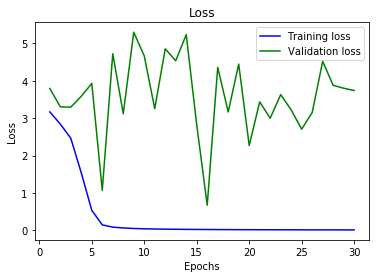

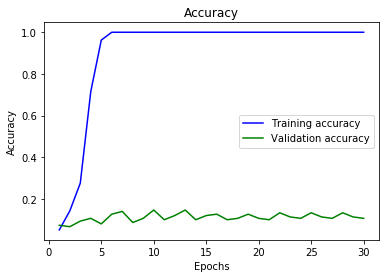

In [21]:
plot_history(hist)

## Evaluate Model

In [22]:
saved_model = load_model('STFTCNN.h5')
test_pred = saved_model.predict_generator(featureGenerator(test_set_files, test_classes), steps=150,verbose=1)

150/150 [==============================] - 59s 392ms/step


In [40]:
predictions_round=np.around(test_pred).astype('int');
predictions_int=np.argmax(predictions_round,axis=1);
predictions_labels=labelencoder.inverse_transform(np.ravel(predictions_int));

In [45]:
predictions_int.shape

(150,)

In [43]:
# Recall - the ability of the classifier to find all the positive samples
print("Recall: ", recall_score(classes_num[test_index], predictions_int,average=None))

# Precision - The precision is intuitively the ability of the classifier not to 
#label as positive a sample that is negative
print("Precision: ", precision_score(classes_num[test_index], predictions_int,average=None))

# F1-Score - The F1 score can be interpreted as a weighted average of the precision 
#and recall
print("F1-Score: ", f1_score(classes_num[test_index], predictions_int, average=None))

# Accuracy - the number of correctly classified samples
print("Accuracy: %.2f  ," % accuracy_score(classes_num[test_index], predictions_int,normalize=True), accuracy_score(classes_num[test_index], predictions_int,normalize=False) )
print("Number of samples:",classes_num[test_index].shape[0])

print(classification_report(classes_num[test_index], predictions_int))

ValueError: Found input variables with inconsistent numbers of samples: [113, 150]

In [42]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(classes_num[test_index], predictions_int)
np.set_printoptions(precision=2)

ValueError: Found input variables with inconsistent numbers of samples: [113, 150]

In [31]:
# Function to Plot Confusion Matrix
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    """
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [32]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(16,12))
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_,
                      title='Confusion matrix, without normalization')

NameError: name 'cnf_matrix' is not defined

<Figure size 1152x864 with 0 Axes>

In [29]:
# Find wrong predicted samples indexes
wrong_predictions = [i for i, (e1, e2) in enumerate(zip(classes_num[test_index], predictions_int)) if e1 != e2]


In [30]:
# Find wrong predicted audio files
print(np.array(labels)[test_index[wrong_predictions]])
print(predictions_labels[wrong_predictions].T)
print(np.array(files)[test_index[wrong_predictions]])

['Pigeon' 'Pheasant' 'Quail' 'Crane' 'other' 'Turaco' 'Lapwing' 'Rail'
 'Nightjar' 'Oystercatcher' 'Rail' 'Sandpiper' 'Lapwing' 'Stilt'
 'Nightjar' 'Dove' 'Nightjar' 'Sandpiper' 'Pigeon' 'Pigeon' 'Pigeon'
 'Dove' 'Grebe' 'Dove' 'Sandpiper' 'Grebe' 'Pheasant' 'Quail' 'Gallinule'
 'Grouse' 'Grebe' 'Gallinule' 'Coot' 'other' 'Coot' 'Crake' 'Nightjar'
 'Quail' 'Swift' 'Pheasant' 'Coot' 'Oystercatcher' 'Stilt' 'Grebe'
 'Plover' 'Gallinule' 'Pheasant' 'Crake' 'Plover' 'Crake' 'Plover' 'Crake'
 'Grouse' 'Pigeon' 'Stilt' 'Grouse' 'Swift' 'Oystercatcher' 'Lapwing'
 'Pheasant' 'Rail' 'Quail' 'Coot' 'Rail' 'Gallinule' 'Dove' 'Turaco'
 'Plover' 'Dove' 'Swift' 'Nightjar' 'Stilt' 'Oystercatcher' 'Crane'
 'Nightjar' 'Grebe' 'Stilt' 'Grouse' 'Lapwing' 'Turaco' 'Grebe'
 'Gallinule' 'Dove' 'other' 'Avocet' 'Gallinule' 'Oystercatcher' 'Turaco'
 'Avocet' 'Crake' 'Rail' 'Gallinule' 'Crane' 'Dove' 'Plover' 'Turaco'
 'Sandpiper' 'Sandpiper' 'Coot' 'Crane' 'Quail' 'Lapwing' 'Crane' 'Swift'
 'Swift' 'Lapwing']